In [1]:
# Let the games begin

import copy

from TicTacToe import TicTacToe
from Agent import RandomAgent, HumanAgent, LearningAgent, PlayingAgent

params = {
    'Q_initial_value' : 0.0, # initial Q value
    # 'Q_initial_value' : 0.0, # initial Q value
    'nr_of_episodes' : 500000, # number of episodes for training
    'epsilon_start' : 0.15,  # initial exploration rate
    'epsilon_min' : 0.005, # minimum exploration rate
    # 'epsilon_start' : 0.5,  # initial exploration rate
    # 'epsilon_min' : 0.25, # minimum exploration rate
    'alpha_start' : 0.1,  # initial learning rate
    'alpha_min' : 0.1, # minimum learning rate
    # 'gamma' : 0.99,  # discount factor
    'gamma' : 0.9,  # discount factor
    'rewards' : {'X': {'X' : 1.0, 'O' : -1.0, 'D' : 0.0}, # rewards for X
                 'O': {'O' : 1.0, 'X' : -1.0, 'D' : 0.0}, # rewards for O
                },
    'switching' : False,
    'debug' : False,
    'optimal_actions' : [],
    'diffs' : [],
    }

nr_of_episodes = 100000
params['nr_of_episodes'] = nr_of_episodes

paramsX = copy.deepcopy(params)
paramsO = copy.deepcopy(params)
paramsX['player'] = 'X'
paramsX['Q_optimal'] = 'TotallySymmetricQ_optimalX.pkl'
paramsO['player'] = 'O'
paramsO['Q_optimal'] = 'TotallySymmetricQ_optimalO.pkl'

outcomes = {'X' : 0, 'O' : 0, 'D' : 0}

learning_agent1 = LearningAgent(paramsX)
learning_agent2 = LearningAgent(paramsO)
random_agent1 = RandomAgent(player='O', switching=False)

# game = TicTacToe(learning_agent1, random_agent1, display=False)
game = TicTacToe(learning_agent1, learning_agent2, display=False)

for episode in range(nr_of_episodes):
    outcome = game.play()
    outcomes[outcome] += 1

print("Outcomes during learning:")
print(f"X wins: {outcomes['X']/nr_of_episodes}, O wins: {outcomes['O']/nr_of_episodes}, draws: {outcomes['D']/nr_of_episodes}")

Outcomes during learning:
X wins: 0.20788, O wins: 0.10067, draws: 0.69145


Number of diffs: 100000


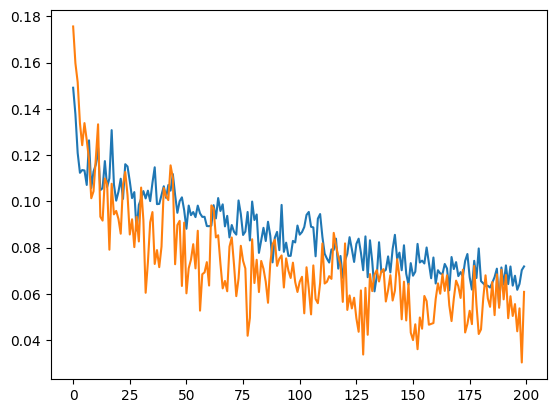

In [3]:
import matplotlib.pyplot as plt

def average(array, chunk_size):
    means = []
    for i in range(0, len(array), chunk_size):
        sublist = array[i:i + chunk_size]
        means.append(sum(sublist)/len(sublist))

    return means

diffsX, diffsO = paramsX['diffs'], paramsO['diffs']
print(f"Number of diffs: {len(diffsX)}")
meansdiffsX = average(diffsX, 500)
meansdiffsO = average(diffsO, 500)

plt.plot(meansdiffsX[:])
plt.plot(meansdiffsO[:])
plt.show()

414860
334038


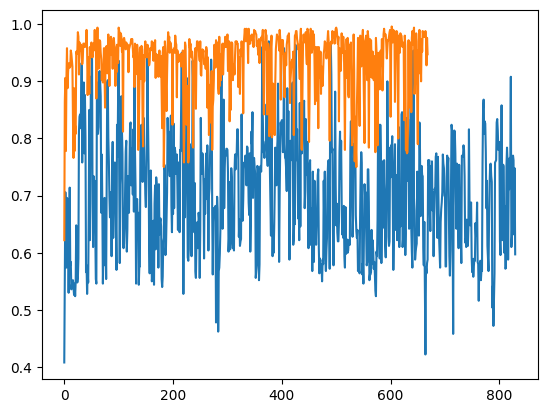

In [4]:
optimal_actionsX = paramsX['optimal_actions']
print(len(optimal_actionsX))
optimal_actionsO = paramsO['optimal_actions']
print(len(optimal_actionsO))

mean_actionsX = average(optimal_actionsX, 500)
mean_actionsO = average(optimal_actionsO, 500)

plt.plot(mean_actionsX)
plt.plot(mean_actionsO)
plt.show()

In [5]:
Q1 = learning_agent1.Q
playing_agent1 = PlayingAgent(Q1, player='X', switching=False)
random_agent1 = RandomAgent(player='O', switching=False)

game = TicTacToe(playing_agent1, random_agent1, display=False)
nr_of_episodes = 20000
outcomes = {'X' : 0, 'O' : 0, 'D' : 0}
for episode in range(nr_of_episodes):
    outcome = game.play()
    outcomes[outcome] += 1

print("Outcomes during playing:")
print(f"X wins: {outcomes['X']/nr_of_episodes}, O wins: {outcomes['O']/nr_of_episodes}, draws: {outcomes['D']/nr_of_episodes}")

Q2 = learning_agent2.Q
playing_agent2 = PlayingAgent(Q2, player='O', switching=False)
random_agent2 = RandomAgent(player='X', switching=False)

game = TicTacToe(playing_agent2, random_agent2, display=False)
nr_of_episodes = 20000
outcomes = {'X' : 0, 'O' : 0, 'D' : 0}
for episode in range(nr_of_episodes):
    outcome = game.play()
    outcomes[outcome] += 1

print("Outcomes during playing:")
print(f"X wins: {outcomes['X']/nr_of_episodes}, O wins: {outcomes['O']/nr_of_episodes}, draws: {outcomes['D']/nr_of_episodes}")

game = TicTacToe(playing_agent1, playing_agent2, display=False)
nr_of_episodes = 20000
outcomes = {'X' : 0, 'O' : 0, 'D' : 0}
for episode in range(nr_of_episodes):
    outcome = game.play()
    outcomes[outcome] += 1

print("Outcomes during playing:")
print(f"X wins: {outcomes['X']/nr_of_episodes}, O wins: {outcomes['O']/nr_of_episodes}, draws: {outcomes['D']/nr_of_episodes}")

Outcomes during playing:
X wins: 0.9867, O wins: 0.0, draws: 0.0133
Outcomes during playing:
X wins: 0.0, O wins: 0.9193, draws: 0.0807
Outcomes during playing:
X wins: 0.0, O wins: 0.0, draws: 1.0


In [ ]:
import numpy as np

from playGame import get_empty_positions

def displayQ(Q, board):
    actions = get_empty_positions(board)  # Assume this function returns indices of empty positions
    Qs = {action: f"{Q.get(tuple(board), action):.2f}" for action in actions}  # Get Q-values, default to 0
    board_size = int(len(board) ** 0.5)  # Assume square board

    # Create a new board layout with Q-values embedded
    Qboard = list(board)
    for action, value in Qs.items():
        Qboard[action] = value  # Replace empty spots with Q-values

    cell_width = 5  # Padding for centering

    # Format and display the board
    for i in range(board_size):
        row = Qboard[i * board_size:(i + 1) * board_size]
        formatted_row = " | ".join(str(cell).center(cell_width) for cell in row)
        print(formatted_row)
        if i < board_size - 1:
            print("-" * (board_size * cell_width + (board_size - 1) * 3))  # Line separator   

    print("\n")

def display_history(Q, history):
    for i in range(len(history)):
        board, action = history[i]
        displayQ(Q, board)

Q1 = learning_agent1.Q
historyX = paramsX['history']
Q2 = learning_agent2.Q
historyO = paramsO['history']
for i in range(min((len(historyX), len(historyO)))):
    board, action = historyO[i]
    displayQ(Q2, board)
    board, action = historyX[i]
    displayQ(Q1, board)

board, action = historyO[len(historyO) - 1]
displayQ(Q1, board)

# if max(len(historyX), len(historyO)) == len(historyX):
#     board, action = historyX[len(historyX) - 1]
#     displayQ(Q1, board)
# else:
#     board, action = historyO[len(historyO) - 1]
#     displayQ(Q2, board)

In [ ]:
import dill

with open('TotallySymmetricQ_optimalX.pkl', 'wb') as f:
    dill.dump(Q1.get(), f)

with open('TotallySymmetricQ_optimalO.pkl', 'wb') as f:
    dill.dump(Q2.get(), f)

In [ ]:
random_outcomes = {'X' : 91/138, 'O' : 44/138, 'D' : 3/138}
print(random_outcomes)

In [ ]:
board = (' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ')
Q1 = learning_agent1.Q
print(Q1.get(board).values())
# Q2 = agent_2.Q
# print(Q2.get(board).values())

In [ ]:
from SymmetricMatrix import TotallySymmetricMatrix, QTotallySymmetricMatrix

board = (' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ')
Q1 = QTotallySymmetricMatrix(default_value=0.0)
Q1.set(board, 0, 1.0)
displayQ(Q1, board)

In [ ]:
print(Q1.get(initialize_board(), 0))
print(Q1.get(initialize_board(), 2))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q_matrix = Q1.get()
# print(f"Total unique states encountered: {len(q_matrix.keys())}")

print(Q1.get(initialize_board()))

# Extract all Q-values from the nested dictionary
# all_q_values = [q for actions in q_matrix.values() for q in actions.values()]
all_q_values = [q for q in q_matrix.values()]
print(f"Total number of elements in Q: {len(all_q_values)}")

mean_q = np.mean(all_q_values)
median_q = np.median(all_q_values)
std_q = np.std(all_q_values)
min_q = np.min(all_q_values)
max_q = np.max(all_q_values)

print("Q-value Statistics:")
print(f"Mean: {mean_q}")
print(f"Median: {median_q}")
print(f"Standard Deviation: {std_q}")
print(f"Minimum: {min_q}")
print(f"Maximum: {max_q}")

plt.figure(figsize=(10, 6))
plt.hist(all_q_values, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Q-values")
plt.xlabel("Q-value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Number of canonical boards: 1520
Number of canonical state-action pairs: 4808

In [ ]:
visits = Visits.get()
# all_v = [v for states in visits.values() for v in states.values()]
all_v = [q for q in visits.values()]

print("Statistics of visited state-action pairs:")
print(f"Number of state-action pairs visited: {len(all_v)}")

mean_v = np.mean(all_v)
median_v = np.median(all_v)
std_v = np.std(all_v)
min_v = np.min(all_v)
max_v = np.max(all_v)

print(f"Mean: {mean_v}")
print(f"Median: {median_v}")
print(f"Standard Deviation: {std_v}")
print(f"Minimum: {min_v}")
print(f"Maximum: {max_v}")

plt.figure(figsize=(10, 6))
plt.hist(all_v, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of visited states")
plt.xlabel("Visits")
plt.ylabel("States")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
rewards = Rewards.get()

# all_r = [r for states in rewards.values() for r in states.values()]
# all_rX = [r for states in rewards.values() for r in states.values() if r == 1.0]
# all_rO = [r for states in rewards.values() for r in states.values() if r == -1.0]
# all_rD = [r for states in rewards.values() for r in states.values() if r == 0.5]

all_r = [r for r in rewards.values()]
all_rX = [r for r in rewards.values() if r == 1.0]
all_rO = [r for r in rewards.values() if r == -1.0]
all_rD = [r for r in rewards.values() if r == 0.5]

print("Statistics of rewards")
print(f"Number of state-action pairs with rewards: {len(all_r)}")
print(f"Number of state-action pairs with rewards for X: {len(all_rX)}")
print(f"Number of state-action pairs with rewards for O: {len(all_rO)}")
print(f"Number of state-action pairs with rewards for D: {len(all_rD)}")